# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [44]:
import findspark
findspark.init()

In [45]:
# Do all imports and installs here
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, mean, to_timestamp
from pyspark.sql.functions import expr, to_date, year
from pyspark.sql.functions import array, col, explode, struct, lit



In [46]:
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import Image

In [47]:
import pyspark # only run after findspark.init()

In [48]:
# Read in the data here
spark = SparkSession.builder.master("local") \
    .appName("US Accidents and Weather EDA") \
    .getOrCreate()
# sc = pyspark.SparkContext(appName="myAppName")


### Step 1: Scope the Project and Gather Data

#### Scope 
    US Accidents Data: This data can be found on Kaggle. It includes several million records of accidents across the US, with details about the severity, location, and timing of each accident.
    US City Demographic Data: This data comes from OpenSoft and includes information by city, state, age, population, veteran status, and race.
    Weather Data: This data can be found on Kaggle or other open data platforms. It includes historical weather conditions by city, including temperature, precipitation, and weather events.

#### Describe and Gather Data 
The end result will be a data warehouse in the cloud (AWS Redshift). It will be used for analytics purposes, allowing the company to identify accident patterns and correlations with weather and demographic factors.

In [49]:
# Load the accidents data
accidents_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/US_Accidents_Dec21_updated.csv')


# Load the weather data
city_attributes_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/city_attributes.csv')
humidity_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/humidity.csv')
pressure_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/pressure.csv')
temperature_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/temperature.csv')
weather_desc_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/weather_description.csv')
wind_direction_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/wind_direction.csv')
wind_speed_df = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load('data/wind_speed.csv')


In [50]:
# Load the demographics data
demographics_df = spark.read.format('csv').option('header','true').option("delimiter", ";").option('inferSchema', 'true').load('data/us-cities-demographics.csv')


In [51]:
# Show the first few records of each dataframe
accidents_df.show()


+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Directi

In [52]:
demographics_df.show()



+-------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|         City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+-------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|       Denver|     Colorado|      34.1|         341137|           341408|          682545|             29363|      113222|                  2.33|        CO|Black or African-...|72288|
|        Provo|         Utah|      23.6|          56231|            59027|          115258|              2177|       10925|    3.2800000000000002|        UT|American Indian a...| 1916|
|      Hampton|     Virginia|      35.5|          66214|            70240| 

In [53]:
city_attributes_df.show()


+-------------+-------------+---------+-----------+
|         City|      Country| Latitude|  Longitude|
+-------------+-------------+---------+-----------+
|    Vancouver|       Canada| 49.24966|-123.119339|
|     Portland|United States|45.523449|-122.676208|
|San Francisco|United States|37.774929|-122.419418|
|      Seattle|United States|47.606209|-122.332069|
|  Los Angeles|United States|34.052231|-118.243683|
|    San Diego|United States|32.715328|-117.157257|
|    Las Vegas|United States|36.174969|-115.137222|
|      Phoenix|United States| 33.44838|-112.074043|
|  Albuquerque|United States|35.084492|-106.651138|
|       Denver|United States|39.739151|-104.984703|
|  San Antonio|United States| 29.42412| -98.493629|
|       Dallas|United States|32.783058| -96.806671|
|      Houston|United States|29.763281| -95.363274|
|  Kansas City|United States|39.099731| -94.578568|
|  Minneapolis|United States|44.979969|  -93.26384|
|  Saint Louis|United States| 38.62727| -90.197891|
|      Chica

In [54]:
humidity_df.show()


+-------------------+---------+--------+-------------+-------+-----------+---------+---------+-------+-----------+------+-----------+------+-------+-----------+-----------+-----------+-------+---------+------------+-------+-------+------------+---------+-----+----------+-------+------------+--------+--------+------+---------+-----------------+-----+-----+---------+---------+
|           datetime|Vancouver|Portland|San Francisco|Seattle|Los Angeles|San Diego|Las Vegas|Phoenix|Albuquerque|Denver|San Antonio|Dallas|Houston|Kansas City|Minneapolis|Saint Louis|Chicago|Nashville|Indianapolis|Atlanta|Detroit|Jacksonville|Charlotte|Miami|Pittsburgh|Toronto|Philadelphia|New York|Montreal|Boston|Beersheba|Tel Aviv District|Eilat|Haifa|Nahariyya|Jerusalem|
+-------------------+---------+--------+-------------+-------+-----------+---------+---------+-------+-----------+------+-----------+------+-------+-----------+-----------+-----------+-------+---------+------------+-------+-------+------------+

In [55]:

temperature_df.show()


+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------------+-------------+-----+---------+---------+
|           datetime|    Vancouver|     Portland|San Francisco|      Seattle|  Los Angeles|    San Diego|    Las Vegas|      Phoenix|  Albuquerque|       Denver|  San Antonio|       Dallas|      Houston|  Kansas City|  Minneapolis|  Saint Louis|      Chicago|    Nashville| Indianapolis|      Atlanta|      Detroit| Jacksonville|    Charlotte|        Miami|   Pittsburgh|      Toronto| Philadelphia|     New York|     Montreal|       Boston|    Beersheba|Tel Aviv District|        Eilat

In [56]:
weather_desc_df.show()
wind_direction_df.show()
wind_speed_df.show()
pressure_df.show()

+-------------------+-------------+----------------+-------------+----------------+------------+------------+------------+------------+------------+-------------+------------+------------+----------------+------------+----------------+------------+---------------+---------------+---------------+---------------+------------+----------------+---------------+--------------------+----------------+------------+-------------+----------+---------------+------------+---------------+-----------------+-------------+---------------+---------------+---------------+
|           datetime|    Vancouver|        Portland|San Francisco|         Seattle| Los Angeles|   San Diego|   Las Vegas|     Phoenix| Albuquerque|       Denver| San Antonio|      Dallas|         Houston| Kansas City|     Minneapolis| Saint Louis|        Chicago|      Nashville|   Indianapolis|        Atlanta|     Detroit|    Jacksonville|      Charlotte|               Miami|      Pittsburgh|     Toronto| Philadelphia|  New York|      

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [57]:
# Count the number of records in each dataframe
print("Accidents count: ", accidents_df.count())
print("Demographics count: ", demographics_df.count())
print("City attributes count: ", city_attributes_df.count())
print("Humidity count: ", humidity_df.count())
print("Pressure count: ", pressure_df.count())
print("Temperature count: ", temperature_df.count())
print("Weather description count: ", weather_desc_df.count())
print("Wind direction count: ", wind_direction_df.count())
print("Wind speed count: ", wind_speed_df.count())

Accidents count:  2845342
Demographics count:  2891
City attributes count:  36
Humidity count:  45253
Pressure count:  45253
Temperature count:  45253
Weather description count:  45253
Wind direction count:  45253
Wind speed count:  45253


In [58]:

# Print the schema of each dataframe
accidents_df.printSchema()





root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doub

In [59]:
city_attributes_df.printSchema()


root
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [60]:
demographics_df.printSchema()


root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [61]:
humidity_df.printSchema()
pressure_df.printSchema()
temperature_df.printSchema()
weather_desc_df.printSchema()
wind_direction_df.printSchema()
wind_speed_df.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- Vancouver: double (nullable = true)
 |-- Portland: double (nullable = true)
 |-- San Francisco: double (nullable = true)
 |-- Seattle: double (nullable = true)
 |-- Los Angeles: double (nullable = true)
 |-- San Diego: double (nullable = true)
 |-- Las Vegas: double (nullable = true)
 |-- Phoenix: double (nullable = true)
 |-- Albuquerque: double (nullable = true)
 |-- Denver: double (nullable = true)
 |-- San Antonio: double (nullable = true)
 |-- Dallas: double (nullable = true)
 |-- Houston: double (nullable = true)
 |-- Kansas City: double (nullable = true)
 |-- Minneapolis: double (nullable = true)
 |-- Saint Louis: double (nullable = true)
 |-- Chicago: double (nullable = true)
 |-- Nashville: double (nullable = true)
 |-- Indianapolis: double (nullable = true)
 |-- Atlanta: double (nullable = true)
 |-- Detroit: double (nullable = true)
 |-- Jacksonville: double (nullable = true)
 |-- Charlotte: double (nullable = true)
 |-- Miam

**Identifying Missing Values**

In [62]:
### Identifying Missing Values

# Get list of columns in the DataFrame
columns = accidents_df.columns

# Initialize an empty list to hold column expressions
column_exprs = []

# For each column, create an expression that counts null values
for c in columns:
    column_expr = sum(col(c).isNull().cast("int")).alias(c)
    column_exprs.append(column_expr)

# Select these column expressions from the DataFrame
null_counts_df = accidents_df.select(*column_exprs)

# Display the result
null_counts_df.show()

+---+--------+----------+--------+---------+---------+-------+-------+------------+-----------+-------+------+----+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description| Number|Street|Side|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|N

**    Identifying Duplicates**

In [63]:
duplicates = accidents_df.count() - accidents_df.distinct().count()
print("Number of duplicate rows: ", duplicates)


Number of duplicate rows:  0


**Identifying Missing Values**

In [64]:
### Identifying Missing Values

# Get list of columns in the DataFrame
columns = accidents_df.columns

# Initialize an empty list to hold column expressions
column_exprs = []

# For each column, create an expression that counts null values
for c in columns:
    column_expr = sum(col(c).isNull().cast("int")).alias(c)
    column_exprs.append(column_expr)

# Select these column expressions from the DataFrame
null_counts_df = accidents_df.select(*column_exprs)

# Display the result
null_counts_df.show()

+---+--------+----------+--------+---------+---------+-------+-------+------------+-----------+-------+------+----+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description| Number|Street|Side|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|N

Looking at the DataFrame summary we provided, it's evident that several columns have missing values. Whether we need to address this depends on the specific requirements of our project and how we plan to use the data.

Here are some general considerations:

    Columns with Missing Values: We need to examine which columns have missing values. If a column is not critical to our analysis and has a substantial amount of missing values, we might consider excluding it. For instance, 'Wind_Chill(F)' and 'Precipitation(in)' have many missing values and may not be critical for a traffic accidents analysis.

    Rows with Missing Values: If only a small fraction of rows have missing values, we might consider removing those rows, particularly if they're not crucial to our analysis.

    Imputation: If a column is critical to our analysis and has some missing values, we might consider imputing the missing values (i.e., filling them in based on other data). For example, we could fill missing values in the 'Temperature(F)' column with the average temperature.

    Data Completeness: We must consider the completeness of our data. If there are many missing values, our analysis might be biased. For instance, if we're missing weather conditions for a certain region or time period, any analysis related to weather conditions might be skewed.

In [65]:
# Filter rows in accidents_df that are between 2016 and 2021
accidents_df = accidents_df.filter((year("Start_Time") >= 2016) & (year("Start_Time") <= 2021))
accidents_df.count()

2845342

In [66]:
# Assuming 'datetime' is the time column in all your dataframes
humidity_df = humidity_df.withColumn("datetime", to_timestamp("datetime"))
pressure_df = pressure_df.withColumn("datetime", to_timestamp("datetime"))
temperature_df = temperature_df.withColumn("datetime", to_timestamp("datetime"))
weather_desc_df = weather_desc_df.withColumn("datetime", to_timestamp("datetime"))
wind_direction_df = wind_direction_df.withColumn("datetime", to_timestamp("datetime"))
wind_speed_df = wind_speed_df.withColumn("datetime", to_timestamp("datetime"))

# Filter for years 2016 and 2017
humidity_df = humidity_df.filter((year("datetime") >= 2016) & (year("datetime") <= 2017))
pressure_df = pressure_df.filter((year("datetime") >= 2016) & (year("datetime") <= 2017))
temperature_df = temperature_df.filter((year("datetime") >= 2016) & (year("datetime") <= 2017))
weather_desc_df = weather_desc_df.filter((year("datetime") >= 2016) & (year("datetime") <= 2017))
wind_direction_df = wind_direction_df.filter((year("datetime") >= 2016) & (year("datetime") <= 2017))
wind_speed_df = wind_speed_df.filter((year("datetime") >= 2016) & (year("datetime") <= 2017))

In [67]:

print("Humidity count: ", humidity_df.count())
print("Pressure count: ", pressure_df.count())
print("Temperature count: ", temperature_df.count())
print("Weather description count: ", weather_desc_df.count())
print("Wind direction count: ", wind_direction_df.count())
print("Wind speed count: ", wind_speed_df.count())

Humidity count:  16777
Pressure count:  16777
Temperature count:  16777
Weather description count:  16777
Wind direction count:  16777
Wind speed count:  16777


**Cleaning Steps**

In [68]:
# Remove missing values
accidents_df = accidents_df.na.drop()
demographics_df = demographics_df.na.drop()
city_attributes_df = city_attributes_df.na.drop()
humidity_df = humidity_df.na.drop()
pressure_df = pressure_df.na.drop()
temperature_df = temperature_df.na.drop()
weather_desc_df = weather_desc_df.na.drop()
wind_direction_df = wind_direction_df.na.drop()
wind_speed_df = wind_speed_df.na.drop()


In [69]:
# Remove duplicates
accidents_df = accidents_df.dropDuplicates()
demographics_df = demographics_df.dropDuplicates()
city_attributes_df = city_attributes_df.dropDuplicates()
humidity_df = humidity_df.dropDuplicates()
pressure_df = pressure_df.dropDuplicates()
temperature_df = temperature_df.dropDuplicates()
weather_desc_df = weather_desc_df.dropDuplicates()
wind_direction_df = wind_direction_df.dropDuplicates()
wind_speed_df = wind_speed_df.dropDuplicates()

In [71]:
# Drop columns with a large number of missing values
accidents_df = accidents_df.drop('Wind_Chill(F)', 'Precipitation(in)')

# Drop rows with missing values in critical columns
accidents_df = accidents_df.na.drop(subset=["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)"])

# Impute missing values in 'Temperature(F)' column with its mean
mean_val = accidents_df.select(mean(accidents_df['Temperature(F)'])).collect()[0][0]
accidents_df = accidents_df.na.fill(mean_val, subset=['Temperature(F)'])


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Conceptual Data Model:

    Snowlake schema is chosen as it's simple, yet effective for this use case.
    Fact table: Accidents data.
    Dimension tables: Demographics and Weather.

A Snowflake Schema is essentially an extension of the Star Schema, where some dimension tables are normalized, creating additional levels of related tables. This can help to eliminate redundancy and improve data integrity, but it can also make queries more complex due to the need for additional joins.

#### 3.2 Mapping Out Data Pipelines
    Extract data from all sources using PySpark.
    Transform data (clean, format, and aggregate as necessary).
    Load transformed data into Redshift tables.

In [ ]:
# from graphviz import Digraph

# dot = Digraph(comment='Data Model')


# # City_Attributes table
# with dot.subgraph(name='cluster_C') as c:
#     c.attr(color='red')
#     c.node_attr['shape'] = 'rectangle'
#     c.node('C_City', 'City (PK)')
#     c.node('C_Country', 'Country')
#     c.node('C_Latitude', 'Latitude')
#     c.node('C_Longitude', 'Longitude')
#     # ... add all other attributes of city_attributes
#     c.attr(label='City_Attributes')


# # Accidents table
# with dot.subgraph(name='cluster_A') as c:
#     c.attr(color='blue')
#     c.node_attr['shape'] = 'rectangle'
#     c.node('A_ID', 'ID (PK)')
#     c.node('A_S', 'Severity')
#     c.node('A_ST', 'Start_Time')
#     c.node('A_ET', 'End_Time')
#     # ... add all other attributes of accidents
#     c.node('A_City', 'City (FK)')  # assuming city is the foreign key linking to city_attributes
#     c.attr(label='Accidents')


# # Weather table
# with dot.subgraph(name='cluster_W') as c:
#     c.attr(color='green')
#     c.node_attr['shape'] = 'rectangle'
#     c.node('W_datetime', 'datetime')
#     c.node('W_City', 'City (FK)')  # assuming city is the foreign key linking to city_attributes
#     c.node('W_Humidity', 'Humidity')
#     c.node('W_Pressure', 'Pressure')
#     # ... add all other attributes of weather
#     c.attr(label='Weather')

# # Add edges to indicate relationships (foreign keys)
# dot.edge('A_City', 'C_City', constraint='false')
# dot.edge('W_City', 'C_City', constraint='false')

# dot.view()


In [ ]:
# dot.render('data_model', view=True, format='png')
# # Display the PNG file in the notebook


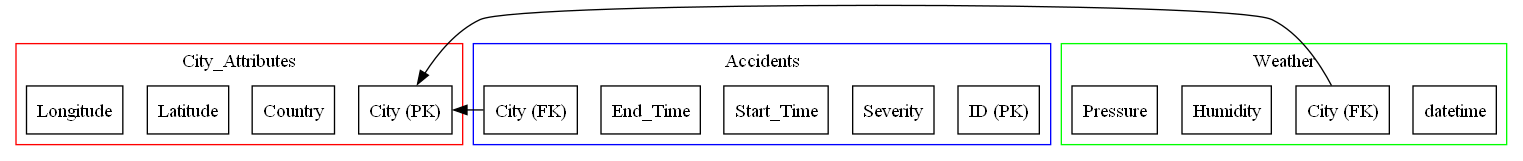

In [ ]:
Image(filename='data_model.png')

### Step 4: Run Pipelines to Model the Data 



#### 4.1 Create the data model
Build the data pipelines to create the data model.

The data model will be based on the Snowlake Schema, where we will have one Fact table and several Dimension tables.

    Fact Table: accidents
    Dimension Tables: demographics, city_attributes, humidity, pressure, temperature, weather_desc, wind_direction, wind_speed.

In [72]:
def unpivot(df):
    # Get the list of all cities (all column names except 'datetime')
    cities = [x for x in df.columns if x != 'datetime']
    
    # Create an array of struct with two fields: 'City' and 'Value'
    df = df.withColumn("City_Value", explode(array([struct(lit(c).alias("City"), col(c).alias("Value")) for c in cities])))
    
    # Select 'datetime' and fields from the struct
    df = df.select("datetime", "City_Value.City", "City_Value.Value")
    
    return df

# Unpivot all weather dataframes
humidity_df = unpivot(humidity_df)
pressure_df = unpivot(pressure_df)
temperature_df = unpivot(temperature_df)
weather_desc_df = unpivot(weather_desc_df)
wind_direction_df = unpivot(wind_direction_df)

# Rename the 'Value' column in each dataframe to correspond to the correct weather attribute
humidity_df = humidity_df.withColumnRenamed('Value', 'Humidity')
pressure_df = pressure_df.withColumnRenamed('Value', 'Pressure')
temperature_df = temperature_df.withColumnRenamed('Value', 'Temperature')
weather_desc_df = weather_desc_df.withColumnRenamed('Value', 'Weather_Description')
wind_direction_df = wind_direction_df.withColumnRenamed('Value', 'Wind_Direction')

In [73]:
# Define the columns that you will keep as identifier variables
id_vars = ["datetime"]

# Assuming value_vars is your list of city names
value_vars = [c for c in wind_speed_df.columns if c not in id_vars]

# Use the stack function to reshape the dataframe
stack_expr = 'stack(' + str(len(value_vars)) + ', ' + ','.join([f"'{c}', `{c}`" for c in value_vars]) + ')'
wind_speed_df = wind_speed_df.select(id_vars + [(expr(stack_expr)).alias('City', 'Wind_Speed')])

# Now you can print the columns to check if the dataframe is in the correct format
print(wind_speed_df.columns)


['datetime', 'City', 'Wind_Speed']


In [74]:
# 1. Fact Table - accidents
accidents_table = accidents_df.select("ID", "Severity", "Start_Time", "End_Time", "Start_Lat", "Start_Lng", "Description", "City", "County", "State", "Zipcode", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Weather_Condition")


# 2. Dimension Table - city_attributes
city_attributes_table = city_attributes_df.select("City", "Country", "Latitude", "Longitude")



# 3. Dimension Table - weather
# Merge weather related dataframes into one
weather_df = humidity_df.join(pressure_df, ["datetime", "City"]).join(temperature_df, ["datetime", "City"]).join(weather_desc_df, ["datetime", "City"]).join(wind_direction_df, ["datetime", "City"]).join(wind_speed_df, ["datetime", "City"])

weather_table = weather_df.select("datetime", "City", "Humidity", "Pressure", "Temperature", "Weather_Description", "Wind_Direction", "Wind_Speed")




In [75]:
# Replace special characters in column names
for col_name in accidents_table.columns:
    clean_col_name = col_name.replace("(", "_").replace(")", "").replace("%", "Perc").replace(".", "")
    accidents_table = accidents_table.withColumnRenamed(col_name, clean_col_name)



In [76]:
accidents_table.show()

+--------+--------+--------------------+--------------------+------------------+-------------------+--------------------+----------------+--------------------+-----+----------+-------------+-------------+-----------+-------------+--------------+--------------+-----------------+
|      ID|Severity|          Start_Time|            End_Time|         Start_Lat|          Start_Lng|         Description|            City|              County|State|   Zipcode|Temperature_F|Humidity_Perc|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|Weather_Condition|
+--------+--------+--------------------+--------------------+------------------+-------------------+--------------------+----------------+--------------------+-----+----------+-------------+-------------+-----------+-------------+--------------+--------------+-----------------+
| A-14923|       2| 2017-01-03 08:43:42| 2017-01-03 14:43:42|         38.805437|         -104.82218|At Southgate Rd -...|Colorado Springs|             El Paso|   C

In [77]:
weather_table.show()

+-------------------+------------+--------+--------+-------------+-------------------+--------------+----------+
|           datetime|        City|Humidity|Pressure|  Temperature|Weather_Description|Wind_Direction|Wind_Speed|
+-------------------+------------+--------+--------+-------------+-------------------+--------------+----------+
|2016-01-01 00:00:00| Albuquerque|    39.0|  1021.0|273.780187225|   scattered clouds|         166.0|       2.0|
|2016-01-01 00:00:00|     Atlanta|    81.0|  1023.0|       283.53|       sky is clear|         330.0|       3.0|
|2016-01-01 00:00:00|   Beersheba|   100.0|   984.0|      282.596|      moderate rain|         254.0|       6.0|
|2016-01-01 00:00:00|      Boston|    61.0|  1016.0|277.207398844|         light rain|         280.0|       3.0|
|2016-01-01 00:00:00|   Charlotte|    93.0|  1020.0|       287.61|               mist|          70.0|       2.0|
|2016-01-01 00:00:00|     Chicago|    79.0|  1025.0|269.470522696|   scattered clouds|         2

In [78]:
city_attributes_table.show()

+-----------------+-------------+---------+-----------+
|             City|      Country| Latitude|  Longitude|
+-----------------+-------------+---------+-----------+
|     Indianapolis|United States|39.768379| -86.158043|
|          Houston|United States|29.763281| -95.363274|
|     Philadelphia|United States|39.952339| -75.163788|
|           Denver|United States|39.739151|-104.984703|
|      Los Angeles|United States|34.052231|-118.243683|
|Tel Aviv District|       Israel|32.083328|  34.799999|
|         Portland|United States|45.523449|-122.676208|
|        Jerusalem|       Israel|31.769039|  35.216331|
|            Haifa|       Israel|32.815559|   34.98917|
|      San Antonio|United States| 29.42412| -98.493629|
|      Minneapolis|United States|44.979969|  -93.26384|
|        Las Vegas|United States|36.174969|-115.137222|
|          Seattle|United States|47.606209|-122.332069|
|     Jacksonville|United States| 30.33218| -81.655647|
|        Beersheba|       Israel| 31.25181|  34.

In [ ]:
# # Write accidents table to parquet file (if not empty)
# if accidents_table.rdd.isEmpty():
#     print("The accidents_table is empty.")
# else:
#     accidents_table.write.mode('overwrite').parquet('data/accidents.parquet')

In [ ]:
# # Write city_attributes table to parquet file (if not empty)
# if city_attributes_table.rdd.isEmpty():
#     print("The city_attributes_table is empty.")
# else:
#     c.write.mode('overwrite').parquet('data/acity_attributes.parquet')

In [80]:
# if weather_table.rdd.isEmpty():
#     print("The weather_table is empty.")
# else:
#     weather_table.write.mode('overwrite').parquet('data/aweather.parquet')

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [81]:
# Integrity Constraints
# Check if there are any rows with null ID in the accidents_table
if accidents_table.filter(accidents_table.ID.isNull()).count() > 0:
    print("Data quality check failed. Found null IDs in accidents_table.")
else:
    print("Data quality check passed. No null IDs found in accidents_table.")

# Check if there are any rows with null City in the city_attributes_table
if city_attributes_table.filter(city_attributes_table.City.isNull()).count() > 0:
    print("Data quality check failed. Found null City in city_attributes_table.")
else:
    print("Data quality check passed. No null City found in city_attributes_table.")

# Check if there are any rows with null datetime or City in the weather_table
if weather_table.filter(weather_table.datetime.isNull() | weather_table.City.isNull()).count() > 0:
    print("Data quality check failed. Found null datetime or City in weather_table.")
else:
    print("Data quality check passed. No null datetime or City found in weather_table.")



Data quality check passed. No null IDs found in accidents_table.
Data quality check passed. No null City found in city_attributes_table.
Data quality check passed. No null datetime or City found in weather_table.


In [82]:
# Source/Count Checks
# Check if the count of rows in the source data matches the count in the final tables
if accidents_df.count() != accidents_table.count():
    print("Count check failed for accidents_table.")
else:
    print("Count check passed for accidents_table.")

if city_attributes_df.count() != city_attributes_table.count():
    print("Count check failed for city_attributes_table.")
else:
    print("Count check passed for city_attributes_table.")

if weather_df.count() != weather_table.count():
    print("Count check failed for weather_table.")
else:
    print("Count check passed for weather_table.")

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.